# **Problem Statement:**

*   To build a CNN based model which can accurately detect melanoma. 
*   Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths
*   A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis


In [1]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Mount the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Data Reading/Data Understanding**

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

**Data Description:**

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Dataset Creation**

In [5]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split= 0.2,
                                                               subset= 'training',
                                                               image_size=(img_height,img_width),
                                                               batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              seed=123,
                                                              validation_split= 0.2,
                                                              subset= 'validation',
                                                              image_size=(img_height,img_width),
                                                              batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Dataset visualisation**

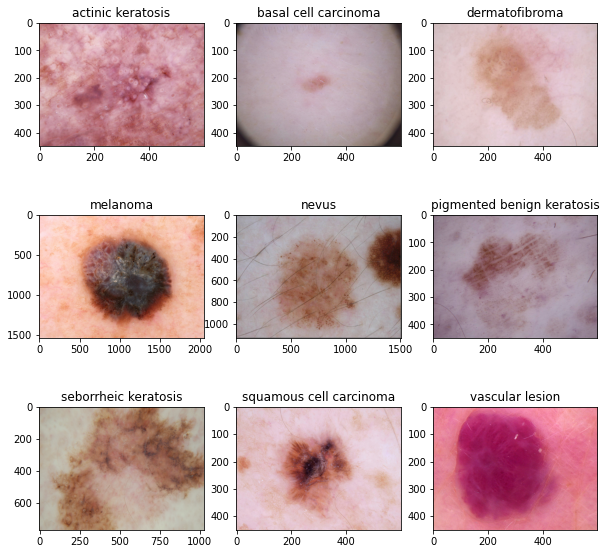

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Model Building & training :**

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 124s 2s/step - loss: 2.0586 - accuracy: 0.1696 - val_loss: 2.0275 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0239 - accuracy: 0.2031 - val_loss: 1.9478 - val_accuracy: 0.2282
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0033 - accuracy: 0.2277 - val_loss: 1.9655 - val_accuracy: 0.2483
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.9463 - accuracy: 0.2500 - val_loss: 1.8616 - val_accuracy: 0.2908
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 1.8866 - accuracy: 0.2907 - val_loss: 1.8282 - val_accuracy: 0.3333
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.7985 - accuracy: 0.3253 - val_loss: 1.7757 - val_accuracy: 0.3289
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 1.7401 - accuracy: 0.3415 - val_loss: 1.7343 - val_accuracy: 0.3848
Epoch 8/20
56/56 [======

### Visualizing training results

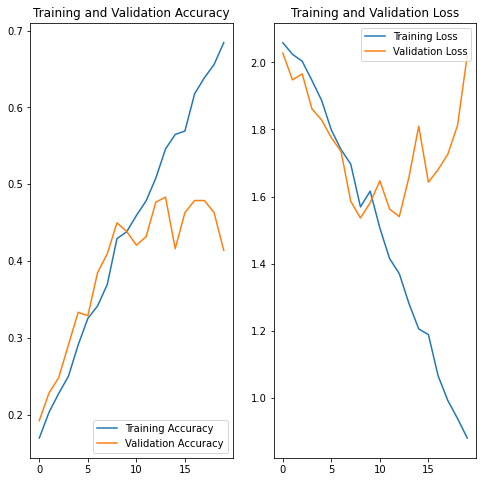

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings on the base model**

- The training accuracy is more as compared to validation accuracy, so we can say that the model is overfitting.

- Also we can see the difference in loss functions in training & validation around the 8-9th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- Lets further train model with increased epochs to check of this issue gets resolved.


Data augumentation strategy

In [16]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

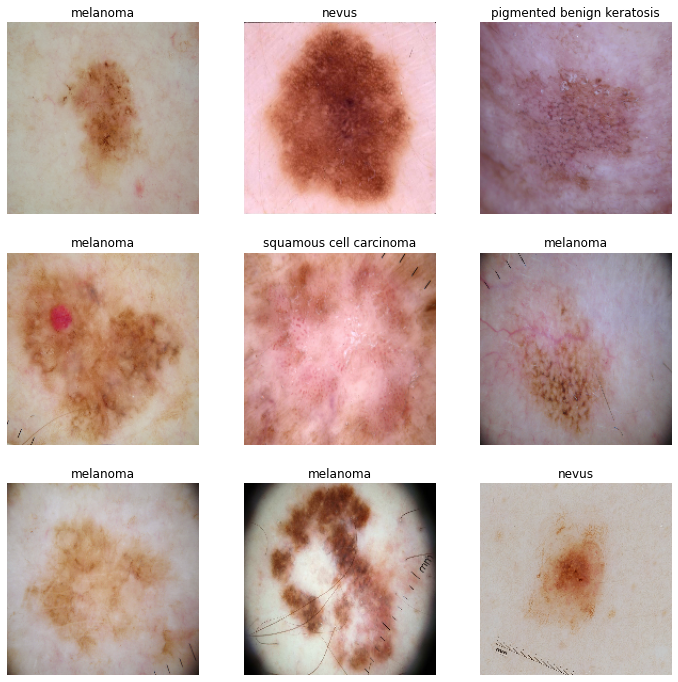

In [17]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [18]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 7s 91ms/step - loss: 2.0745 - accuracy: 0.1948 - val_loss: 2.0535 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 5s 86ms/step - loss: 2.0330 - accuracy: 0.2031 - val_loss: 2.0377 - val_accuracy: 0.2125
Epoch 3/30
56/56 [==============================] - 5s 85ms/step - loss: 1.9339 - accuracy: 0.2595 - val_loss: 1.9439 - val_accuracy: 0.3356
Epoch 4/30
56/56 [==============================] - 5s 85ms/step - loss: 1.8976 - accuracy: 0.2740 - val_loss: 1.9120 - val_accuracy: 0.3221
Epoch 5/30
56/56 [==============================] - 5s 87ms/step - loss: 1.8195 - accuracy: 0.3025 - val_loss: 1.7383 - val_accuracy: 0.3579
Epoch 6/30
56/56 [==============================] - 5s 85ms/step - loss: 1.9635 - accuracy: 0.2651 - val_loss: 1.8585 - val_accuracy: 0.3065
Epoch 7/30
56/56 [==============================] - 5s 85ms/step - loss: 1.8255 - accuracy: 0.3103 - val_loss: 1.8933 - val_accuracy: 0.2595
Epoch 8/30
56

### Visualizing the results

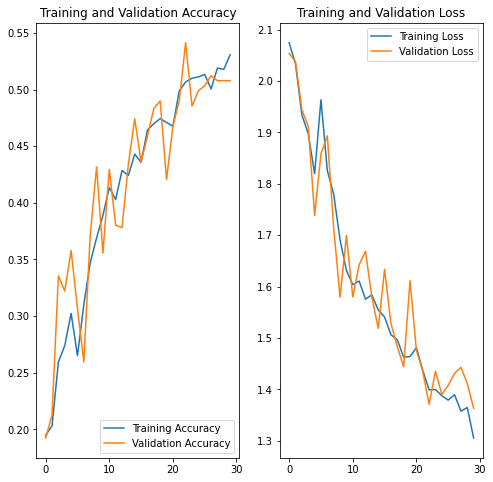

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

- The model is improved as the problem of overfitting is eradicated from it.

- But there is scope of improvement in the accuracy of the model. For this we can try increasing the epochs and retrain the model.

#### **Find the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### Class imbalance findings: 
#### - **seborrheic keratosis** class has the least number of samples.
#### - **pigmented benign keratosis** & **melanoma** classes dominate the data in terms proportionate number of samples.

#### **Rectify the class imbalance**

In [36]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [37]:
import Augmentor
import os
train_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
  p = Augmentor.Pipeline(train_path,save_format='jpg')
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F01CA4F5D50>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F01C8650CD0>: 100%|██████████| 500/500 [00:42<00:00, 11.71 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F025B1ED050>: 100%|██████████| 500/500 [00:42<00:00, 11.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F025008DB90>: 100%|██████████| 500/500 [00:52<00:00,  9.57 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F01CACE9410>: 100%|██████████| 500/500 [00:40<00:00, 12.28 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F01C8AE3150>: 100%|██████████| 500/500 [00:40<00:00, 12.43 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F025B194F10>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F01C8E83850>: 100%|██████████| 500/500 [00:48<00:00, 10.25 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F025B0E1D50>: 100%|██████████| 500/500 [00:43<00:00, 11.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
data_dir = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/")
image_count_train = len(list(data_dir.glob('*/*.jpg')))
print(image_count_train)

11132


Lets see the distribution of augmented data after adding new images to the original training data.


In [39]:
for i in class_names:
    for j in data_dir.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df


,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
13366,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
13367,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
13368,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
13369,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    2774
melanoma                      2537
basal cell carcinoma          2262
nevus                         2218
squamous cell carcinoma       1021
vascular lesion                789
actinic keratosis              741
dermatofibroma                 604
seborrheic keratosis           425
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

11132


In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds

Found 11132 files belonging to 9 classes.
Using 8906 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11132 files belonging to 9 classes.
Using 2226 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## We can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


279/279 [==============================] - 52s 181ms/step - loss: 1.9753 - accuracy: 0.2398 - val_loss: 1.8905 - val_accuracy: 0.3266
Epoch 2/20
279/279 [==============================] - 48s 168ms/step - loss: 1.7270 - accuracy: 0.3699 - val_loss: 1.5866 - val_accuracy: 0.4250
Epoch 3/20
279/279 [==============================] - 57s 200ms/step - loss: 1.4903 - accuracy: 0.4661 - val_loss: 1.4060 - val_accuracy: 0.4892
Epoch 4/20
279/279 [==============================] - 48s 169ms/step - loss: 1.2344 - accuracy: 0.5627 - val_loss: 1.1823 - val_accuracy: 0.5858
Epoch 5/20
279/279 [==============================] - 50s 171ms/step - loss: 1.0250 - accuracy: 0.6416 - val_loss: 1.0384 - val_accuracy: 0.6442
Epoch 6/20
279/279 [==============================] - 47s 167ms/step - loss: 0.8586 - accuracy: 0.7010 - val_loss: 0.9225 - val_accuracy: 0.7071
Epoch 7/20
279/279 [==============================] - 49s 171ms/step - loss: 0.7048 - accuracy: 0.7516 - val_loss: 0.9175 - val_accuracy: 0.7

#### **Todo:**  Visualize the model results

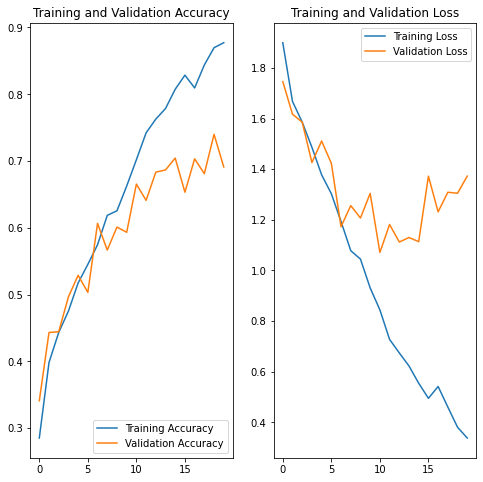

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Conclusions:**
- Accuracy on training data has increased by using Augmentor library
- The Model can be further improved by tuning the hyperparameter
- Model is overfitting
- The problem of overfitting can be solved by adding more layer, neurons or adding dropout layer.
